In [ ]:
%pip install pandas_montecarlo --upgrade --no-cache-dir


# Agenda

For monthly, weekly and daily timeframes
- Establish that distribution is not normal - use d-tale
- Establish that *all* the value lies in the tail 
- Determine at what price are options cost effective (back testing) - pure barbell
- Determine at what price is insurance for a long only portfolio cost effective (back testing)
- Monte Carlo and bust probabilities 
- TODO
    - Capturing the 4th moment strategy 
    - Understand how to calculate alpha of the tail, use Hill estimator and more sophisticated stuff.

In [2]:
import pandas as pd
import numpy as np
import pandas_montecarlo

### Shiller monthly data S&P 500

<http://www.econ.yale.edu/~shiller/data.htm>

In [3]:
# From shiller 
df = pd.read_excel("ie_data.xls", "Data")


In [3]:
df[7:].head(20)

Unnamed: 0 Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4   Unnamed: 5  \
7     1871.01       4.44       0.26        0.4  12.464061  1871.041667   
8     1871.02        4.5       0.26        0.4  12.844641     1871.125   
9     1871.03       4.61       0.26        0.4  13.034972  1871.208333   
10    1871.04       4.74       0.26        0.4  12.559226  1871.291667   
11    1871.05       4.86       0.26        0.4  12.273812     1871.375   
12    1871.06       4.82       0.26        0.4  12.083481  1871.458333   
13    1871.07       4.73       0.26        0.4  12.083481  1871.541667   
14    1871.08       4.79       0.26        0.4  11.893231     1871.625   
15    1871.09       4.84       0.26        0.4  12.178646  1871.708333   
16     1871.1       4.59       0.26        0.4  12.368896  1871.791667   
17    1871.11       4.64       0.26        0.4  12.368896     1871.875   
18    1871.12       4.74       0.26        0.4  12.654392  1871.958333   
19    1872.01       4.86     0.2633     0.4025  12.654392  1872.041667   
20    1872.02       4.88     0.2667      0.405  12.654392     1872.125   
21    1872.03       5.04       0.27     0.4075  12.844641  1872.208333   
22    1872.04       5.18     0.2733       0.41  13.130137  1872.291667   
23    1872.05       5.18     0.2767     0.4125  13.130137     1872.375   
24    1872.06       5.13       0.28      0.415  13.034972  1872.458333   
25    1872.07        5.1     0.2833     0.4175  12.844641  1872.541667   
26    1872.08       5.04     0.2867       0.42  12.939807     1872.625   

   Unnamed: 6  Unnamed: 7 Unnamed: 8  Unnamed: 9  ... Unnamed: 12 Unnamed: 13  \
7        5.32   97.250271   5.694836   97.250271  ...         NaN         NaN   
8    5.323333   95.644049   5.526101   96.104557  ...         NaN         NaN   
9    5.326667   96.551327   5.445411   97.472173  ...         NaN         NaN   
10       5.33  103.034548   5.651684  104.492692  ...         NaN         NaN   
11   5.333333  108.099637   5.783108  110.118209  ...         NaN         NaN   
12   5.336667  108.898625     5.8742  111.430773  ...         NaN         NaN   
13       5.34  106.865248     5.8742  109.851015  ...         NaN         NaN   
14   5.343333  109.951982   5.968166  113.535234  ...         NaN         NaN   
15   5.346667  108.496009   5.828298  112.533332  ...         NaN         NaN   
16       5.35  101.309267   5.738651  105.575174  ...         NaN         NaN   
17   5.353333  102.412853   5.738651  107.223588  ...         NaN         NaN   
18   5.356667  102.259693   5.609181  107.552623  ...         NaN         NaN   
19       5.36  104.848546   5.680375   110.77334  ...         NaN         NaN   
20   5.378333  105.280022   5.753726  111.735769  ...         NaN         NaN   
21   5.396667  107.121335   5.738643  114.197535  ...         NaN         NaN   
22      5.415  107.703029   5.682478  115.322475  ...         NaN         NaN   
23   5.433333  107.703029   5.753171  115.835823  ...         NaN         NaN   
24   5.451667  107.442149   5.864289  116.080837  ...         NaN         NaN   
25       5.47  108.396589   6.021324  117.654138  ...         NaN         NaN   
26   5.488333  106.333515   6.048774  115.961982  ...         NaN         NaN   

   Unnamed: 14  Unnamed: 15 Unnamed: 16  Unnamed: 17 Unnamed: 18 Unnamed: 19  \
7          NaN          NaN         NaN     1.004177           1    0.130609   
8          NaN          NaN         NaN      1.00418    0.974424    0.130858   
9          NaN          NaN         NaN     1.004183    0.964209    0.130951   
10         NaN          NaN         NaN     1.004185    1.004919    0.122056   
11         NaN          NaN         NaN     1.004188    1.032591    0.122638   
12         NaN          NaN         NaN     1.004191    1.053249    0.123093   
13         NaN          NaN         NaN     1.004194    1.057663    0.120022   
14         NaN          NaN         NaN     1.004197    1.079088    0.111933   
15         NaN          Na

In [42]:
# get percent change m-o-m
monthly = df[7:1808].copy()
monthly.rename(columns={"Unnamed: 1": "close"}, inplace=True)
monthly["pct"] = pd.to_numeric(monthly["close"]).pct_change()
stdev_m = monthly["pct"].std()
# print stdev as percentage
print("Stdev monthly ", stdev_m * 100)

Stdev monthly  4.0696146685580254


### Daily data for DOW from NASDAQ and Yahoo Finance

<https://data.nasdaq.com/data/BCB/UDJIAD1-dow-jones-industrial-average>
<https://finance.yahoo.com/quote/%5EDJI/history/>

In [5]:
df5 = pd.read_csv("/Users/shan/Documents/RWRI Code/USETHIS.csv")
df5 = df5[5400:] # Because mkt was closed for 6mo

df5.head(10)
df5['Datetime'] = pd.to_datetime(df5['Date'])
df5.set_index(['Datetime'], inplace=True)
df5['Value'] = df5['Value'].str.replace(',', '').astype(float)
df5["Value"] = pd.to_numeric(df5["Value"], downcast="float")

In [6]:
weekly = df5["Value"].resample('W').ohlc()
weekly["pct"] = weekly["close"].pct_change()
weekly.head()
stdev_w = weekly["pct"].std()
print("Stdev weekly ", stdev_w * 100)

Stdev weekly  2.5032687932252884


In [7]:
daily = df5["Value"].resample('1D').ohlc()
daily["pct"] = daily["close"].pct_change()
daily.head()
stdev_d = daily["pct"].std()
print("Stdev daily ", stdev_d * 100)

Stdev daily  0.9442564100027084


# Does the tail contain all the information? 

* we try with cost of options = 0 first

In [43]:
def gainFn(row, threshold):
    """ Function which returns the gains of an options contract."""
    if row["pct"] > threshold:
        return row["pct"] - threshold
    elif -row["pct"] > threshold:
        return -row["pct"] - threshold
    else:
        return 0

def tailCapture(df, winThreshold, gainFn=gainFn):
    df["gain_pct"] = df.apply(lambda row: gainFn(row, winThreshold), axis=1)

    startingPortfolioVal = df.head(1)["close"].values[0]
    portfolioVal = startingPortfolioVal
    oldPfVal = startingPortfolioVal  # Only for sanity checks
    pfList = [startingPortfolioVal]
    # shift the gain by 1 week for comparison and iterate over all rows of df
    for _, row in df.shift(-1).iterrows():
        if np.isnan(row["gain_pct"]):
            continue
        portfolioVal += portfolioVal * row["gain_pct"]
        oldPfVal += oldPfVal * row["pct"] # For sanity checks
        pfList.append(portfolioVal)
    df["portfolio"] = pfList
    print(
        "Strategy ending val ",
        portfolioVal,
        "Discrete periods ",
        len(pfList),
        len(df),
        "Ending val buy and hold ",
        df.tail(1)["close"].values[0],
        oldPfVal,
    )


In [65]:
def plot(df, winThreshold):
    wins = df[(df["pct"] > winThreshold) | (df["pct"] < -winThreshold)][
        ["pct", "gain_pct"]
    ]
    wins.plot(
        kind="bar",
        ylim=(-1, 1),
        figsize=(20, 6),
        grid=True,
        yticks=tuple(np.arange(-1, 1, 0.1)),
    )
    print(wins.describe(), "\n", wins)
    # Longest seq of zeros
    s = df["gain_pct"] == 0
    print("Longest streak of 0s: ", (~s).cumsum()[s].value_counts().max())
    # Longest seq of non-zeros
    s = df["gain_pct"] != 0
    print("Longest streak of non 0s: ", (~s).cumsum()[s].value_counts().max())
    df[["portfolio", "close"]].plot(figsize=(20, 6), grid=True, logy=True)


def montecarlo(df, title, col):
    mc = df[col].montecarlo(sims=100, bust=-0.25, goal=2)
    mc.plot(title=title, figsize=(20, 6))
    print(title, mc.stats)


#### Monthly, 1 SD

Strategy ending val  117269.03930371544 Discrete periods  1801 1801 Ending val buy and hold  3793.748421052632 3793.748421052611
              pct    gain_pct
count  395.000000  395.000000
mean     0.004781    0.026755
std      0.077602    0.038521
min     -0.264737    0.000041
25%     -0.054922    0.006402
50%      0.042697    0.016186
75%      0.057282    0.031290
max      0.502994    0.462298 
            pct  gain_pct
16   -0.051653  0.010957
39   -0.076459  0.035763
40   -0.087146  0.046450
42    0.094059  0.053363
43    0.054299  0.013602
...        ...       ...
1798  0.041314  0.000618
1799  0.057075  0.016379
1800  0.063380  0.022684
1802  0.057392  0.016696
1806  0.041228  0.000532

[395 rows x 2 columns]
Longest streak of 0s:  48
Longest streak of non 0s:  7


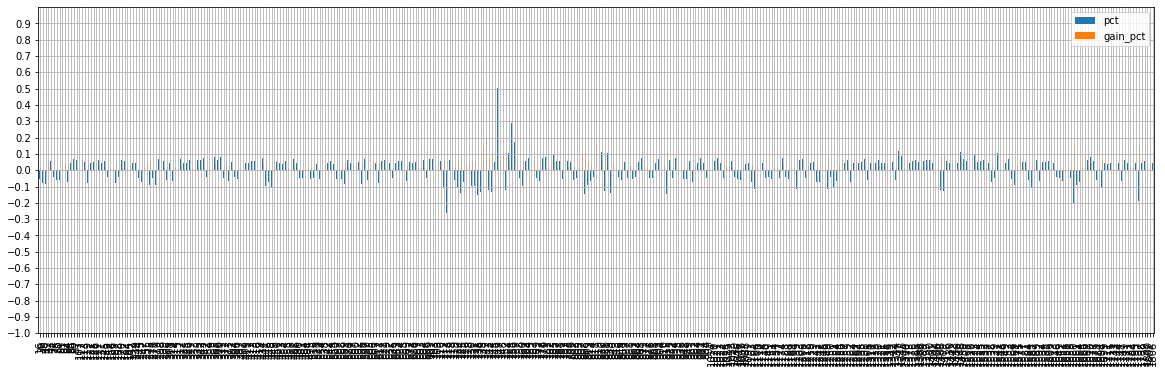

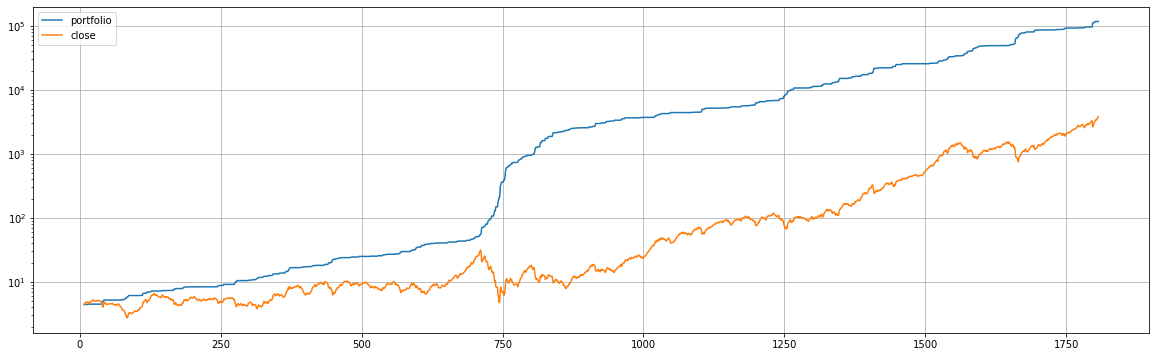

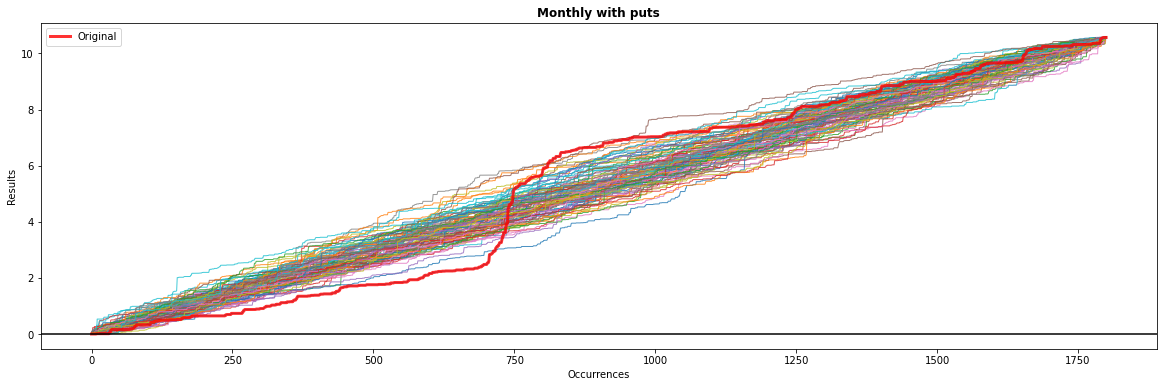

Monthly with puts {'min': 10.568074679106, 'max': 10.568074679106026, 'mean': 10.568074679106013, 'median': 10.568074679106013, 'std': 6.004044710110732e-15, 'maxdd': nan, 'bust': 0.0, 'goal': 1.0}


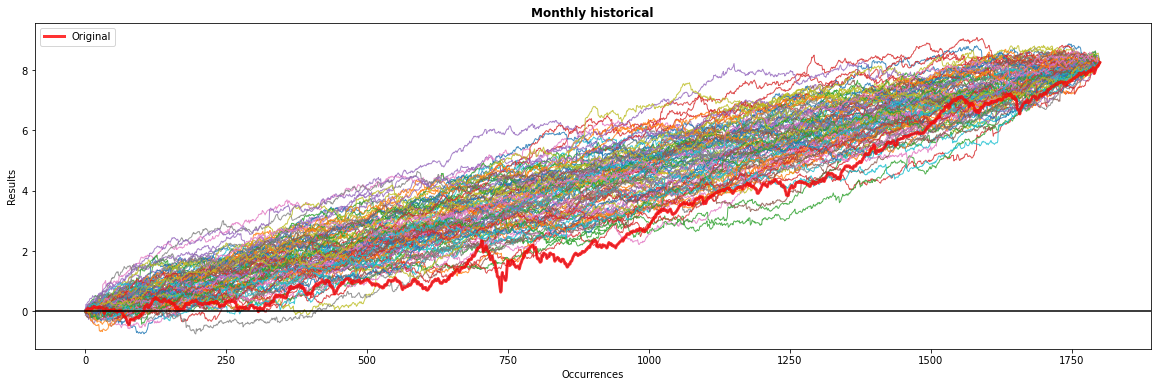

Monthly historical {'min': 8.2501323318792, 'max': 8.250132331879257, 'mean': 8.250132331879223, 'median': 8.250132331879225, 'std': 1.015900180236374e-14, 'maxdd': -0.7499916396378578, 'bust': 0.18, 'goal': 0.82}


In [52]:
tailCapture(monthly, stdev_m)   
plot(monthly, stdev_m)
montecarlo(monthly, "Monthly with puts", "gain_pct")
montecarlo(monthly, "Monthly historical", "pct")

#### Monthly 2 SD

Strategy ending val  79.7128222647148 Discrete periods  1801 1801 Ending val buy and hold  3793.748421052632 3793.748421052611
             pct   gain_pct
count  70.000000  70.000000
mean   -0.035129   0.043708
std     0.135881   0.061958
min    -0.264737   0.000462
25%    -0.120222   0.010923
50%    -0.092605   0.026120
75%     0.091630   0.050254
max     0.502994   0.421602 
            pct  gain_pct
40   -0.087146  0.005754
42    0.094059  0.012667
112   0.109005  0.027612
275  -0.088512  0.007120
277  -0.093275  0.011883
...        ...       ...
1660 -0.203911  0.122519
1661 -0.088522  0.007130
1666  0.120217  0.038825
1694 -0.105555  0.024162
1797 -0.190681  0.109288

[70 rows x 2 columns]
Longest streak of 0s:  188
Longest streak of non 0s:  3


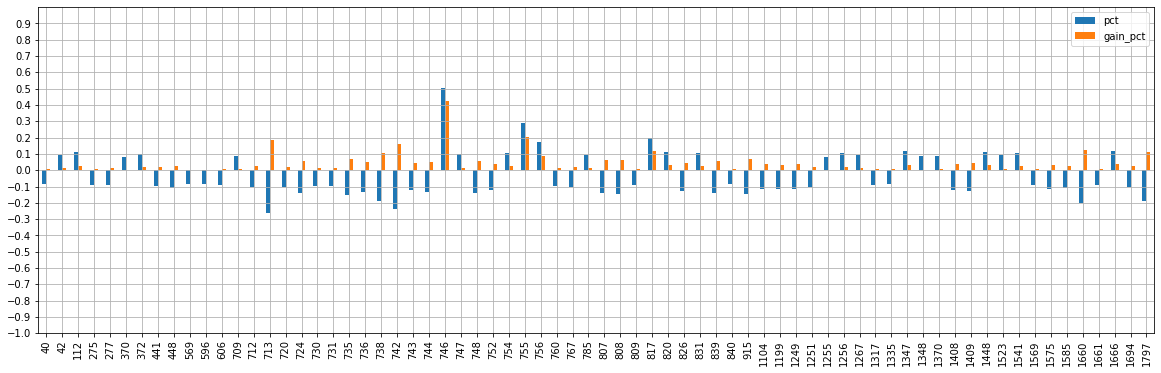

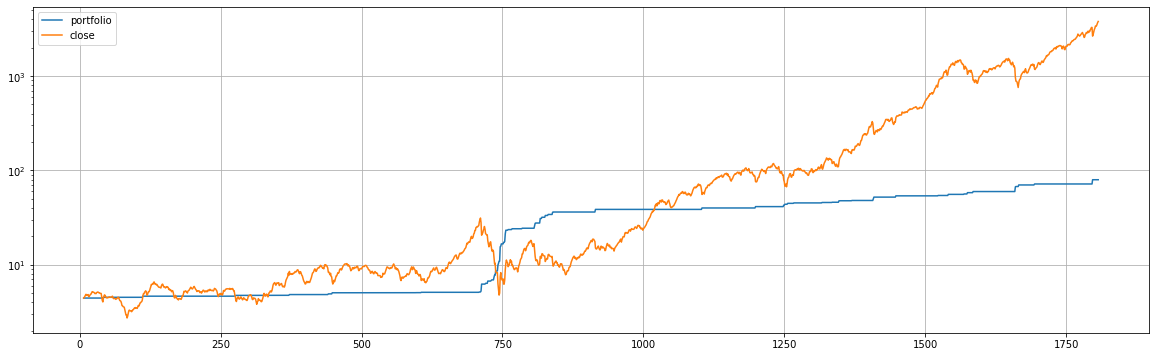

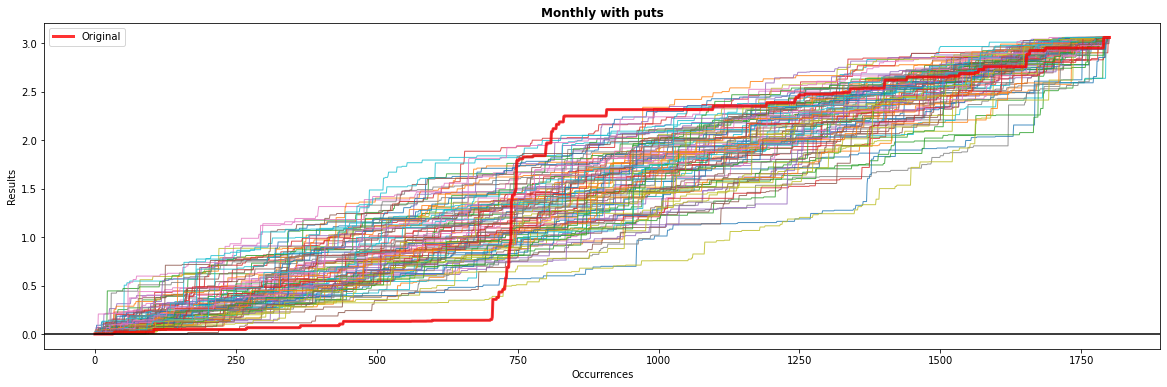

Monthly with puts {'min': 3.059546090803638, 'max': 3.059546090803642, 'mean': 3.05954609080364, 'median': 3.0595460908036403, 'std': 9.222880070799276e-16, 'maxdd': nan, 'bust': 0.0, 'goal': 1.0}


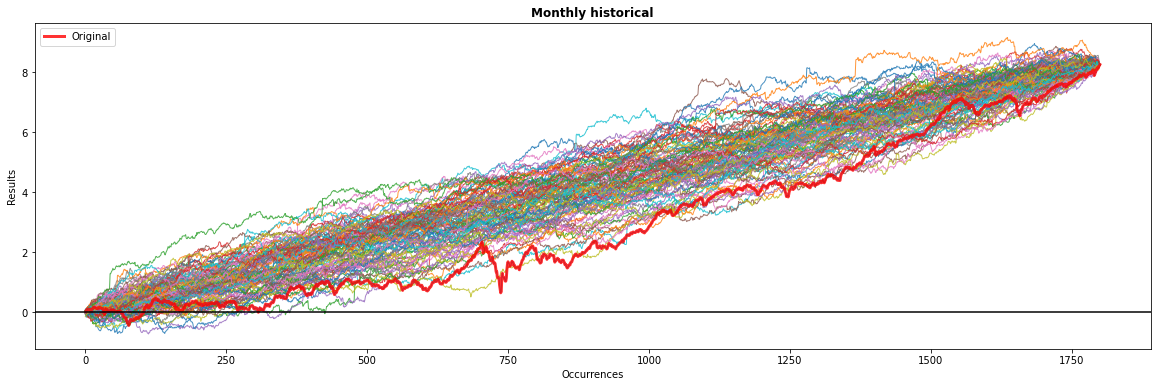

Monthly historical {'min': 8.250132331879207, 'max': 8.250132331879248, 'mean': 8.250132331879223, 'median': 8.250132331879225, 'std': 8.03784245356947e-15, 'maxdd': -0.7347676079043778, 'bust': 0.2, 'goal': 0.8}


In [53]:
tailCapture(monthly, stdev_m*2)   
plot(monthly, stdev_m*2)
montecarlo(monthly, "Monthly with puts", "gain_pct")
montecarlo(monthly, "Monthly historical", "pct")

#### Weekly 2 SD

Strategy ending val  32449.949832745588 Discrete periods  5582 5582 Ending val buy and hold  34483.72 34483.66855370661
              pct    gain_pct
count  270.000000  270.000000
mean    -0.006267    0.024262
std      0.079256    0.027854
min     -0.181513    0.000242
25%     -0.066454    0.006176
50%     -0.051956    0.014767
75%      0.060448    0.030299
max      0.226686    0.176621 
                  pct  gain_pct
Datetime                      
1915-04-11  0.059522  0.009457
1915-04-18  0.068304  0.018238
1915-05-09 -0.122221  0.072155
1915-05-23  0.057646  0.007580
1915-06-06  0.060152  0.010086
...              ...       ...
2020-04-12  0.126675  0.076610
2020-06-07  0.068072  0.018006
2020-06-14 -0.055529  0.005463
2020-11-01 -0.064723  0.014658
2020-11-08  0.068743  0.018678

[270 rows x 2 columns]
Longest streak of 0s:  620
Longest streak of non 0s:  8


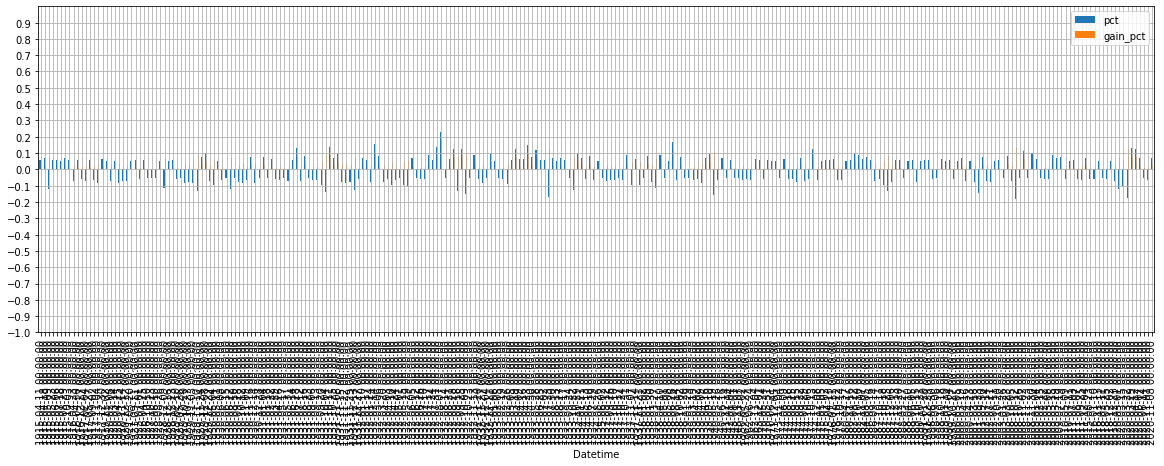

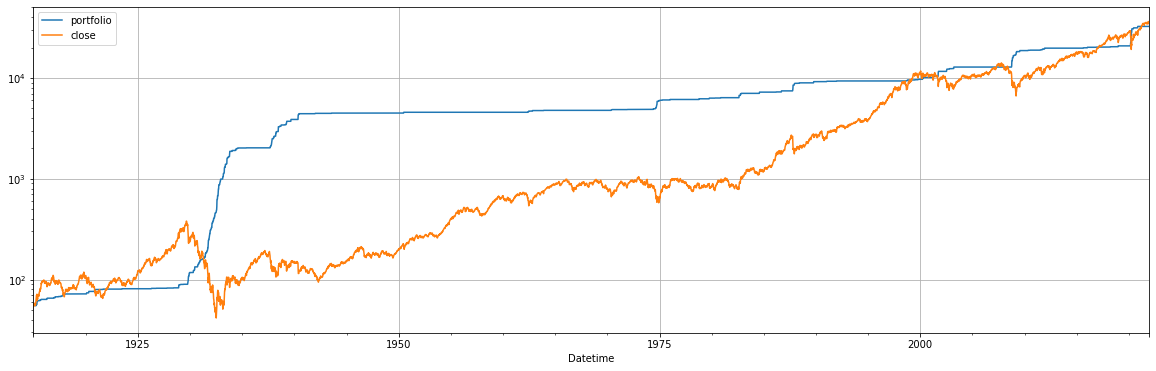

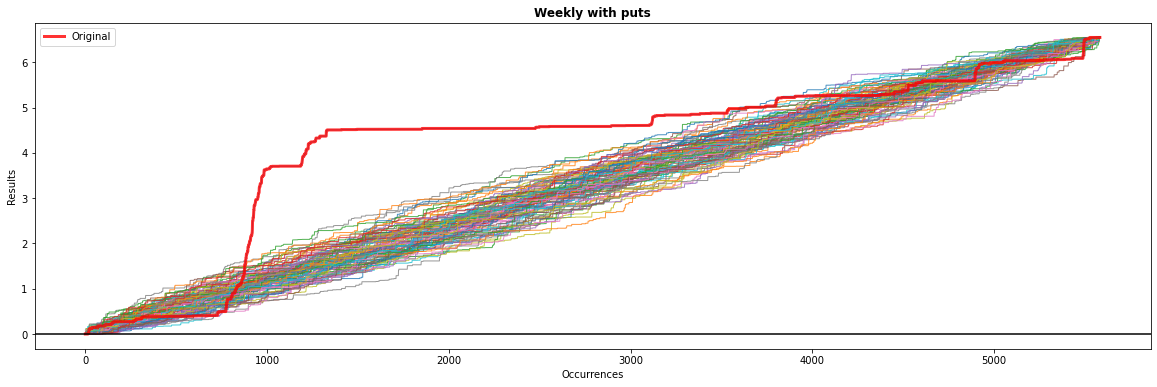

Weekly with puts {'min': 6.550715997815132, 'max': 6.550715997815132, 'mean': 6.550715997815132, 'median': 6.550715997815132, 'std': 0.0, 'maxdd': nan, 'bust': 0.0, 'goal': 1.0}


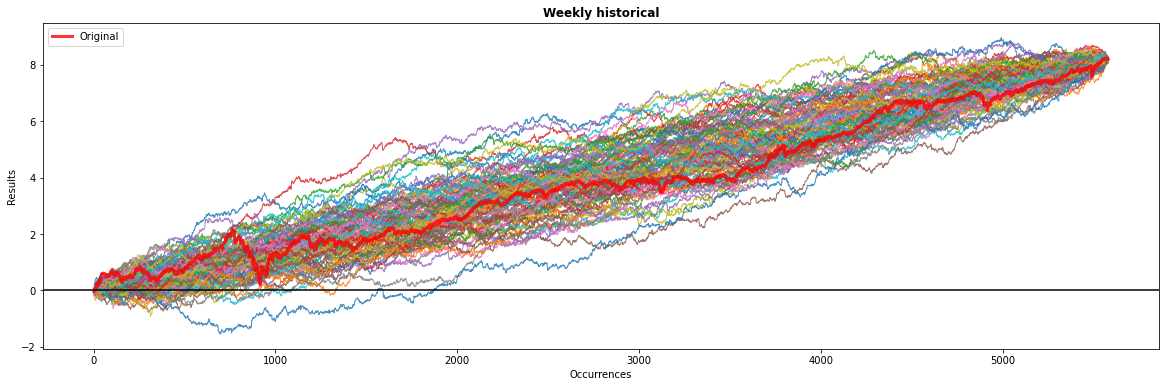

Weekly historical {'min': 8.19879025220871, 'max': 8.19879025220871, 'mean': 8.19879025220871, 'median': 8.19879025220871, 'std': 0.0, 'maxdd': -1.5443972945213318, 'bust': 0.32, 'goal': 0.68}


In [54]:
tailCapture(weekly, stdev_w*2)   
plot(weekly, stdev_w*2)
montecarlo(weekly, "Weekly with puts", "gain_pct")
montecarlo(weekly, "Weekly historical", "pct")

#### Weekly 2 SD, Puts-only, calls-only

Strategy ending val  1001.0715237562532 Discrete periods  5582 5582 Ending val buy and hold  34483.72 34483.66855370661
              pct    gain_pct
count  270.000000  270.000000
mean    -0.006267    0.011037
std      0.079256    0.022903
min     -0.181513    0.000000
25%     -0.066454    0.000000
50%     -0.051956    0.000000
75%      0.060448    0.010382
max      0.226686    0.176621 
                  pct  gain_pct
Datetime                      
1915-04-11  0.059522  0.009457
1915-04-18  0.068304  0.018238
1915-05-09 -0.122221  0.000000
1915-05-23  0.057646  0.007580
1915-06-06  0.060152  0.010086
...              ...       ...
2020-04-12  0.126675  0.076610
2020-06-07  0.068072  0.018006
2020-06-14 -0.055529  0.000000
2020-11-01 -0.064723  0.000000
2020-11-08  0.068743  0.018678

[270 rows x 2 columns]
Longest streak of 0s:  1086
Longest streak of non 0s:  4


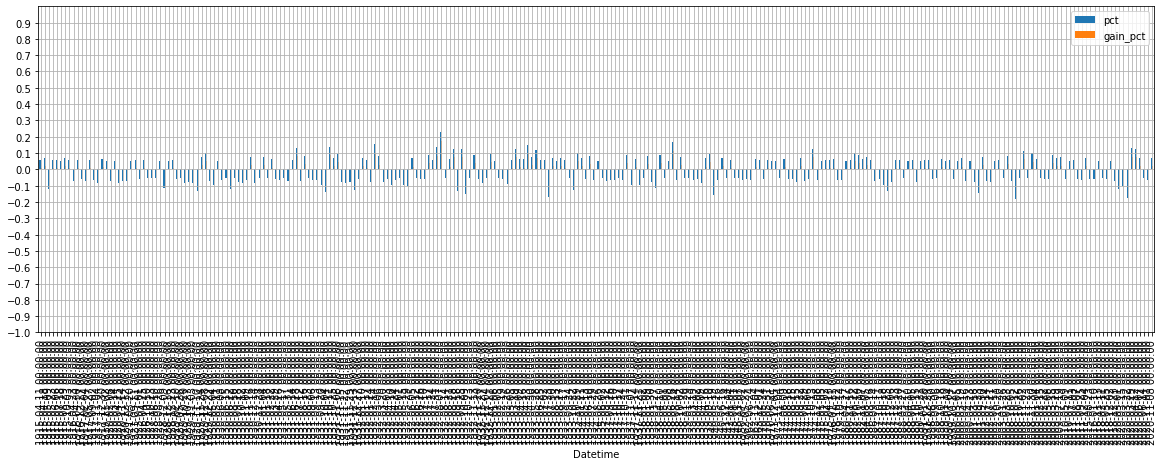

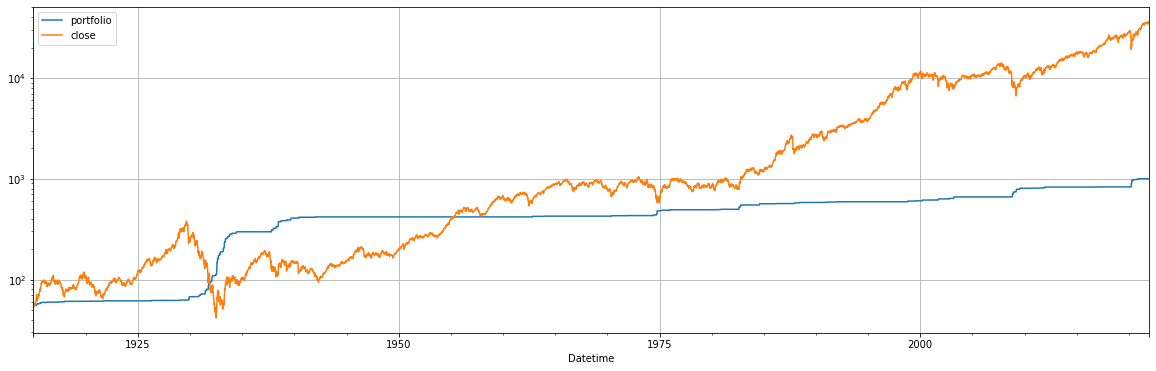

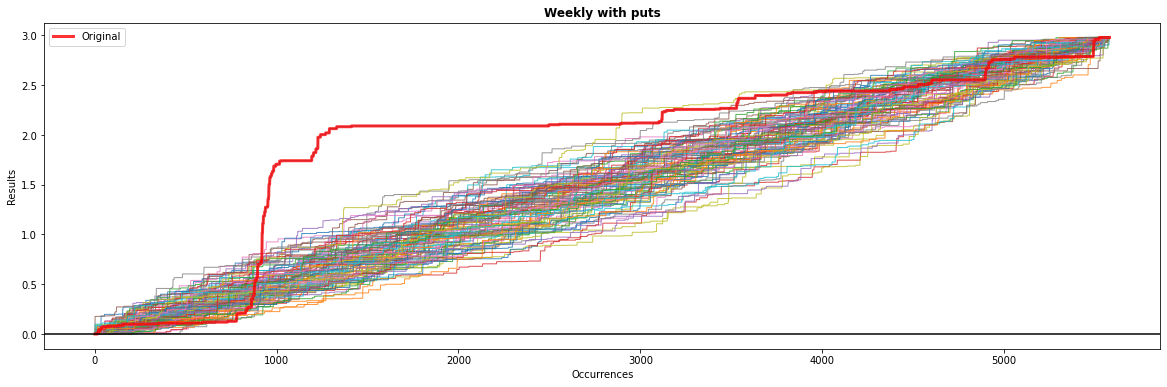

Weekly with puts {'min': 2.9800523817539215, 'max': 2.9800523817539215, 'mean': 2.9800523817539215, 'median': 2.9800523817539215, 'std': 0.0, 'maxdd': nan, 'bust': 0.0, 'goal': 1.0}


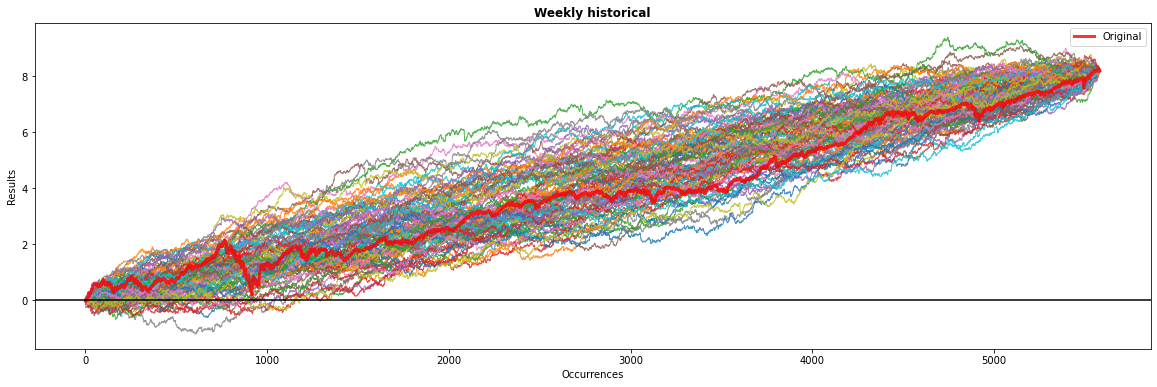

Weekly historical {'min': 8.19879025220871, 'max': 8.19879025220871, 'mean': 8.19879025220871, 'median': 8.19879025220871, 'std': 0.0, 'maxdd': -1.206438422203064, 'bust': 0.31, 'goal': 0.69}


In [55]:
def gainFnCallsOnly(row, threshold):
    """ Function which returns the gains of an options contract."""
    if row["pct"] > threshold:
        return row["pct"] - threshold
    else:
        return 0

tailCapture(weekly, stdev_w*2, gainFn=gainFnCallsOnly)   
plot(weekly, stdev_w*2)
montecarlo(weekly, "Weekly with puts", "gain_pct")
montecarlo(weekly, "Weekly historical", "pct")

Strategy ending val  1789.3199566837782 Discrete periods  5582 5582 Ending val buy and hold  34483.72 34483.66855370661
              pct    gain_pct
count  270.000000  270.000000
mean    -0.006267    0.013225
std      0.079256    0.023330
min     -0.181513    0.000000
25%     -0.066454    0.000000
50%     -0.051956    0.001890
75%      0.060448    0.016389
max      0.226686    0.131448 
                  pct  gain_pct
Datetime                      
1915-04-11  0.059522  0.000000
1915-04-18  0.068304  0.000000
1915-05-09 -0.122221  0.072155
1915-05-23  0.057646  0.000000
1915-06-06  0.060152  0.000000
...              ...       ...
2020-04-12  0.126675  0.000000
2020-06-07  0.068072  0.000000
2020-06-14 -0.055529  0.005463
2020-11-01 -0.064723  0.014658
2020-11-08  0.068743  0.000000

[270 rows x 2 columns]
Longest streak of 0s:  620
Longest streak of non 0s:  4


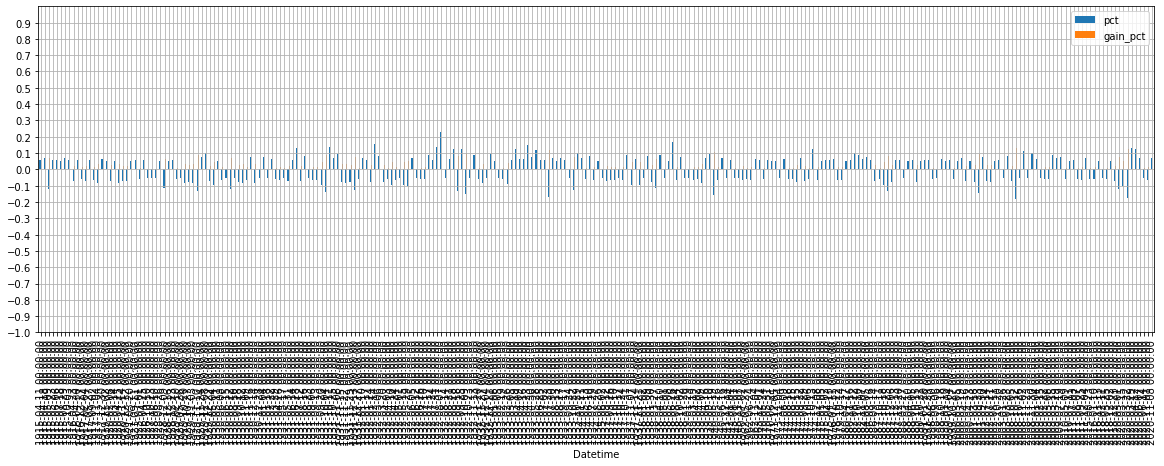

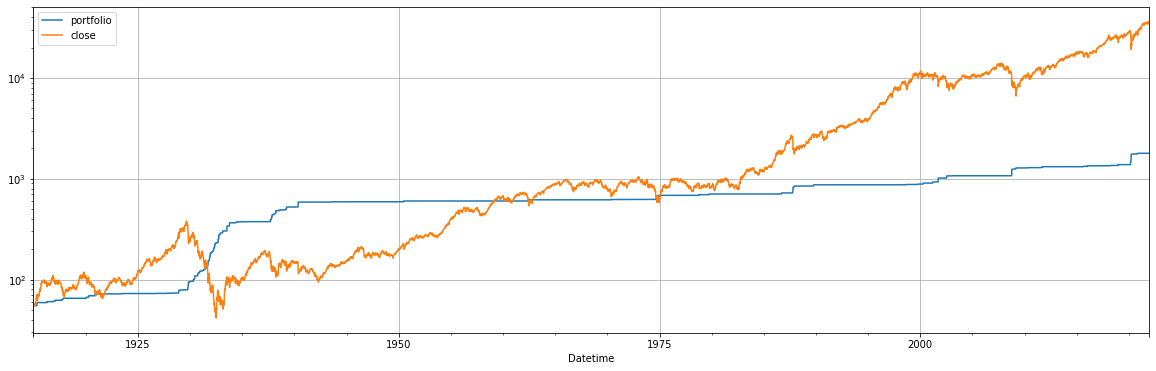

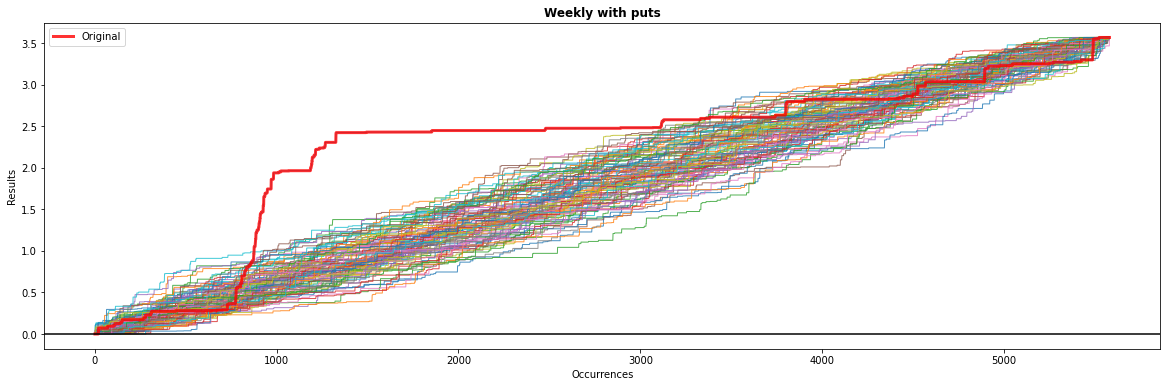

Weekly with puts {'min': 3.5706636160612106, 'max': 3.5706636160612106, 'mean': 3.5706636160612106, 'median': 3.5706636160612106, 'std': 0.0, 'maxdd': nan, 'bust': 0.0, 'goal': 1.0}


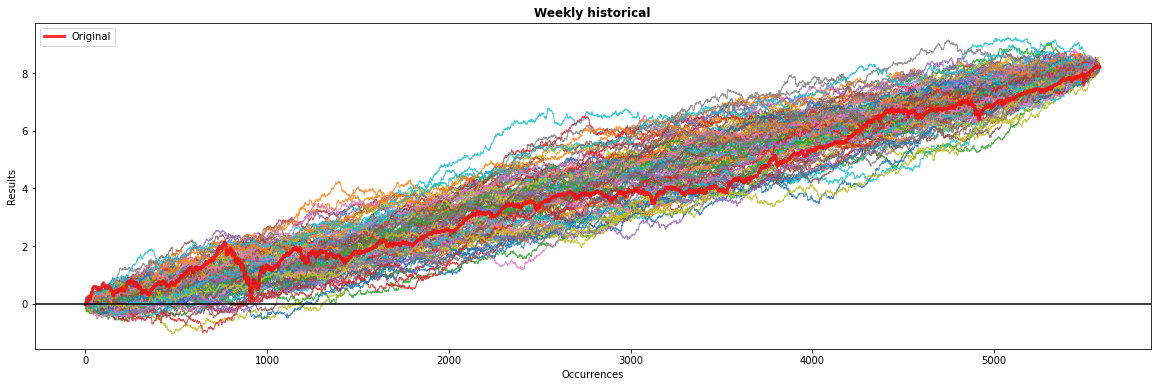

Weekly historical {'min': 8.19879025220871, 'max': 8.19879025220871, 'mean': 8.19879025220871, 'median': 8.19879025220871, 'std': 0.0, 'maxdd': -1.0432822108268738, 'bust': 0.31, 'goal': 0.69}


In [56]:
def gainFnPutsOnly(row, threshold):
    """ Function which returns the gains of an options contract."""
    if -row["pct"] > threshold:
        return -row["pct"] - threshold
    else:
        return 0

tailCapture(weekly, stdev_w*2, gainFn=gainFnPutsOnly)   
plot(weekly, stdev_w*2)
montecarlo(weekly, "Weekly with puts", "gain_pct")
montecarlo(weekly, "Weekly historical", "pct")

### NOTES

* As we get more datapoints (number of datapoints at the weekly level is more than monthly), we find that it diverges instead of converging!
* Capturing *only* the puts or only the calls is not the right strategy

#### Weekly 3 SD

Strategy ending val  702.6614522670303 Discrete periods  5582 5582 Ending val buy and hold  34483.72 34483.66855370661
             pct   gain_pct
count  83.000000  83.000000
mean   -0.011651   0.031547
std     0.110812   0.030081
min    -0.181513   0.000140
25%    -0.095724   0.008257
50%    -0.076504   0.020698
75%     0.094650   0.050606
max     0.226686   0.151588 
                  pct  gain_pct
Datetime                      
1915-05-09 -0.122221  0.047123
1917-11-04 -0.083513  0.008415
1920-04-25 -0.083198  0.008100
1928-12-09 -0.115096  0.039998
1929-10-20 -0.081715  0.006617
...              ...       ...
2020-03-01 -0.123586  0.048488
2020-03-15 -0.103583  0.028485
2020-03-22 -0.173023  0.097925
2020-03-29  0.128445  0.053347
2020-04-12  0.126675  0.051577

[83 rows x 2 columns]
Longest streak of 0s:  1794
Longest streak of non 0s:  4


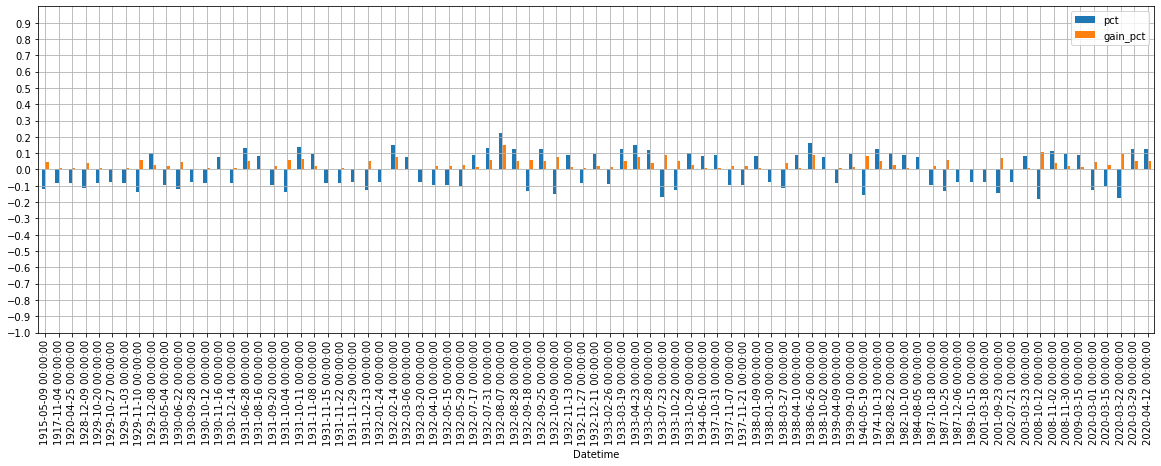

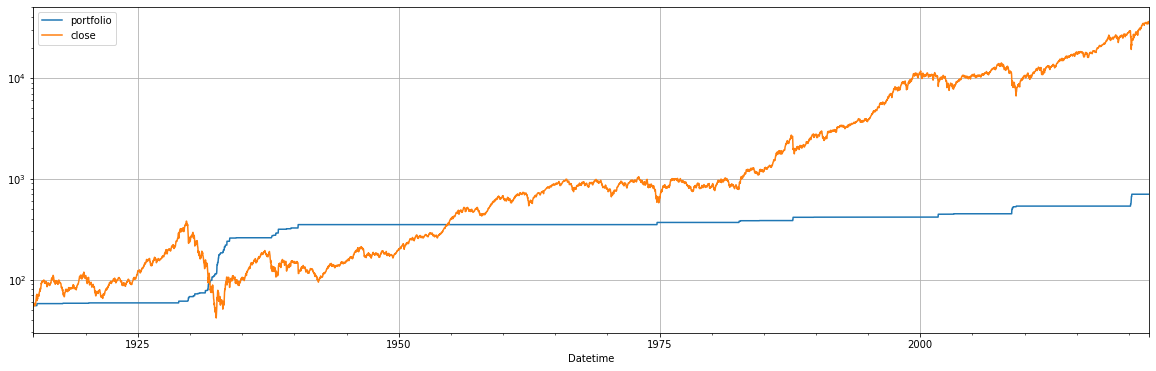

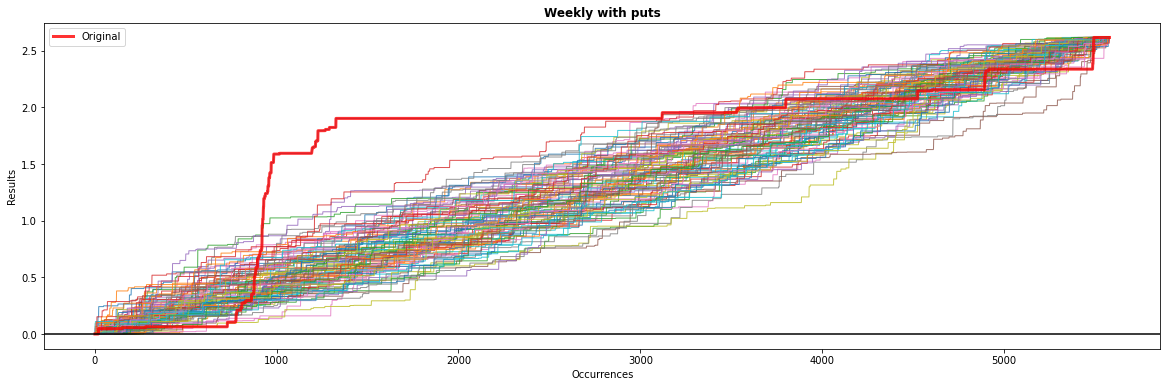

Weekly with puts {'min': 2.6184235624969006, 'max': 2.6184235624969006, 'mean': 2.6184235624969006, 'median': 2.6184235624969006, 'std': 0.0, 'maxdd': nan, 'bust': 0.0, 'goal': 1.0}


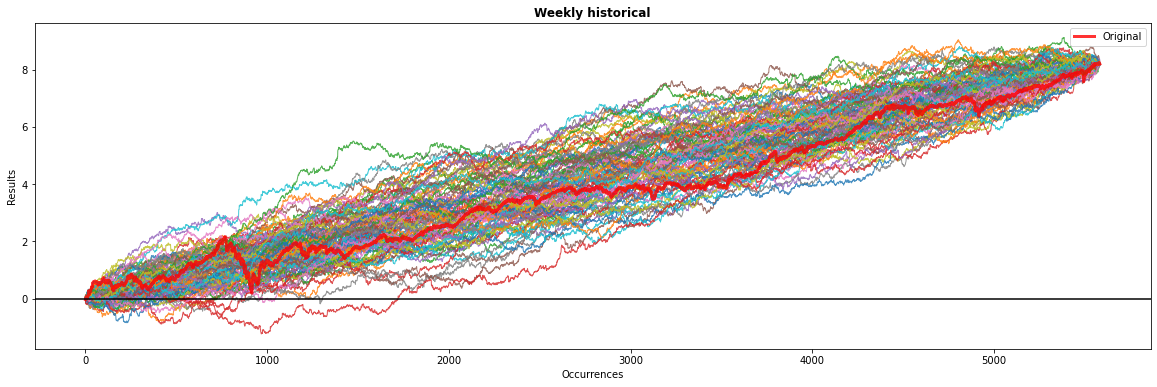

Weekly historical {'min': 8.19879025220871, 'max': 8.19879025220871, 'mean': 8.19879025220871, 'median': 8.19879025220871, 'std': 0.0, 'maxdd': -1.2396610379219055, 'bust': 0.25, 'goal': 0.75}


In [57]:
tailCapture(weekly, stdev_w*3)   
plot(weekly, stdev_w*3)
montecarlo(weekly, "Weekly with puts", "gain_pct")
montecarlo(weekly, "Weekly historical", "pct")

#### Daily 3SD

Strategy ending val  1027458.287416707 Discrete periods  39069 39069 Ending val buy and hold  34483.72 34483.845736697476
              pct    gain_pct
count  711.000000  711.000000
mean    -0.002768    0.014035
std      0.045921    0.017868
min     -0.226105    0.000021
25%     -0.037786    0.003135
50%     -0.029226    0.008209
75%      0.035363    0.018472
max      0.153417    0.197778 
                  pct  gain_pct
Datetime                      
1914-12-15 -0.029774  0.001447
1915-02-02  0.030041  0.001714
1915-04-09  0.029612  0.001284
1915-04-16  0.028775  0.000447
1915-05-05 -0.029463  0.001135
...              ...       ...
2020-06-05  0.031549  0.003221
2020-06-11 -0.068982  0.040654
2020-06-26 -0.028356  0.000029
2020-10-28 -0.034346  0.006018
2020-11-09  0.029466  0.001138

[711 rows x 2 columns]
Longest streak of 0s:  2371
Longest streak of non 0s:  5


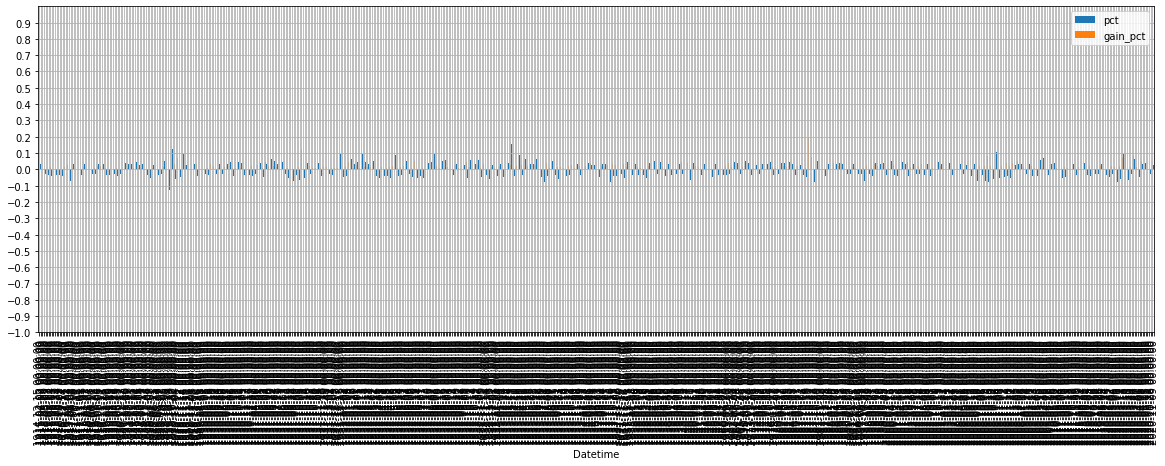

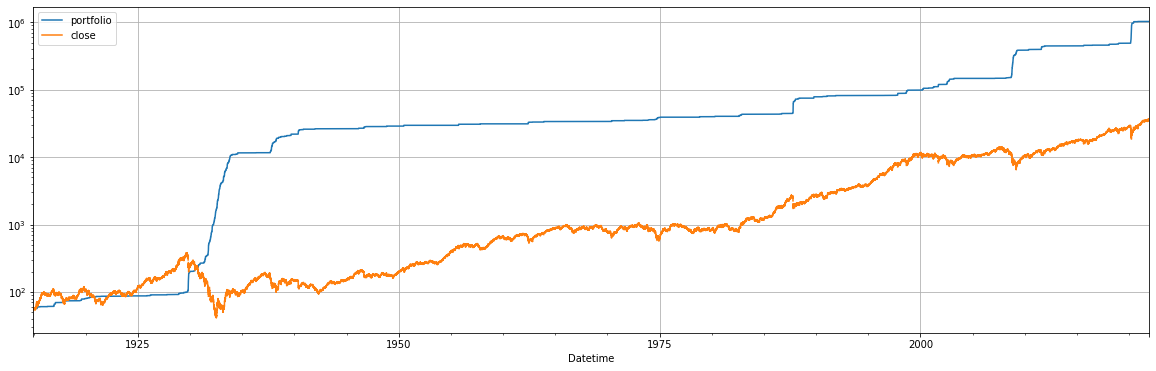

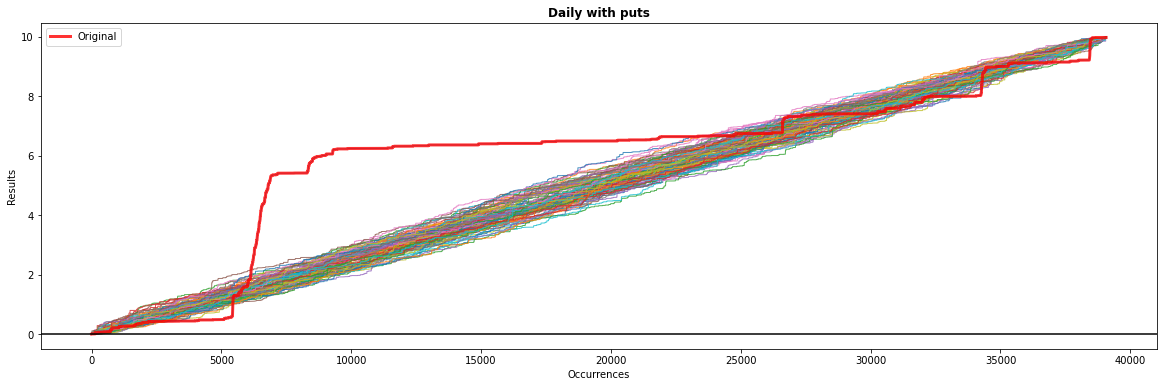

Daily with puts {'min': 9.979025024920702, 'max': 9.979025024920702, 'mean': 9.979025024920702, 'median': 9.979025024920702, 'std': 0.0, 'maxdd': nan, 'bust': 0.0, 'goal': 1.0}


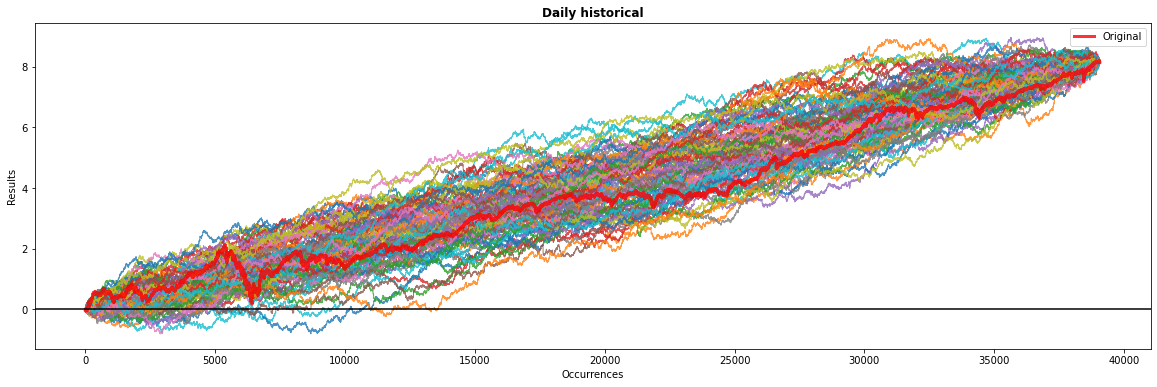

Daily historical {'min': 8.155999302864075, 'max': 8.155999302864075, 'mean': 8.155999302864075, 'median': 8.155999302864075, 'std': 0.0, 'maxdd': -0.8164742588996887, 'bust': 0.3, 'goal': 0.7}


In [58]:
tailCapture(daily, stdev_d*3)   
plot(daily, stdev_d*3)
montecarlo(daily, "Daily with puts", "gain_pct")
montecarlo(daily, "Daily historical", "pct")

Strategy ending val  69168.93213368767 Discrete periods  39069 39069 Ending val buy and hold  34483.72 34483.845736697476
              pct    gain_pct
count  472.000000  472.000000
mean    -0.002839    0.015343
std      0.052064    0.019286
min     -0.226105    0.000010
25%     -0.042682    0.003557
50%     -0.034332    0.009367
75%      0.041955    0.018909
max      0.153417    0.193056 
                  pct  gain_pct
Datetime                      
1915-05-07 -0.045435  0.012386
1915-05-08 -0.036235  0.003186
1915-05-11  0.041573  0.008524
1915-05-14 -0.041739  0.008690
1916-04-22 -0.035751  0.002702
...              ...       ...
2020-04-06  0.077305  0.044256
2020-04-08  0.034418  0.001369
2020-05-18  0.038503  0.005454
2020-06-11 -0.068982  0.035933
2020-10-28 -0.034346  0.001297

[472 rows x 2 columns]
Longest streak of 0s:  2373
Longest streak of non 0s:  5


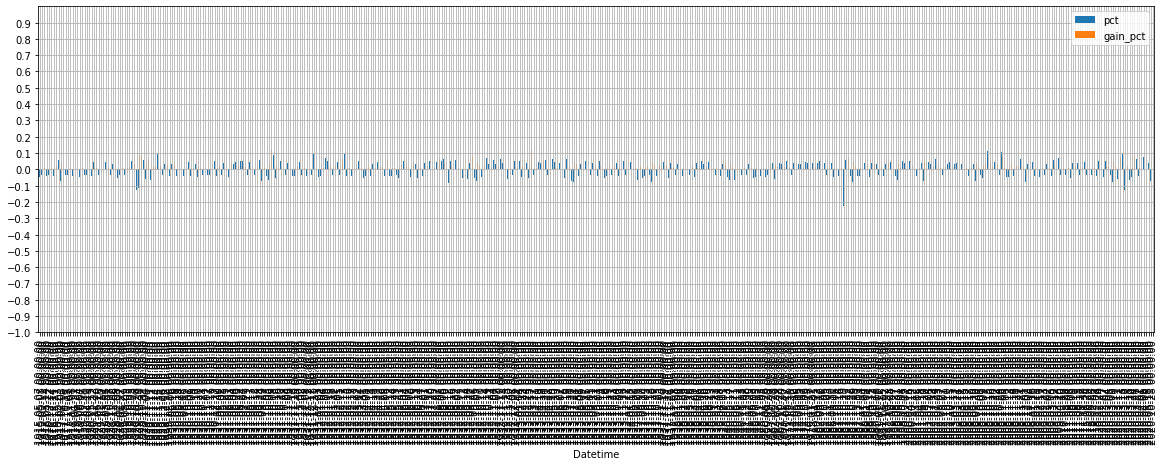

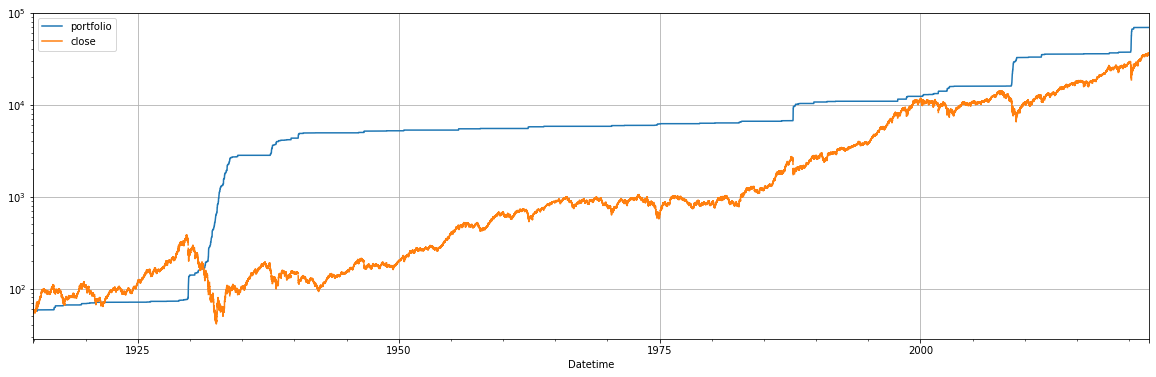

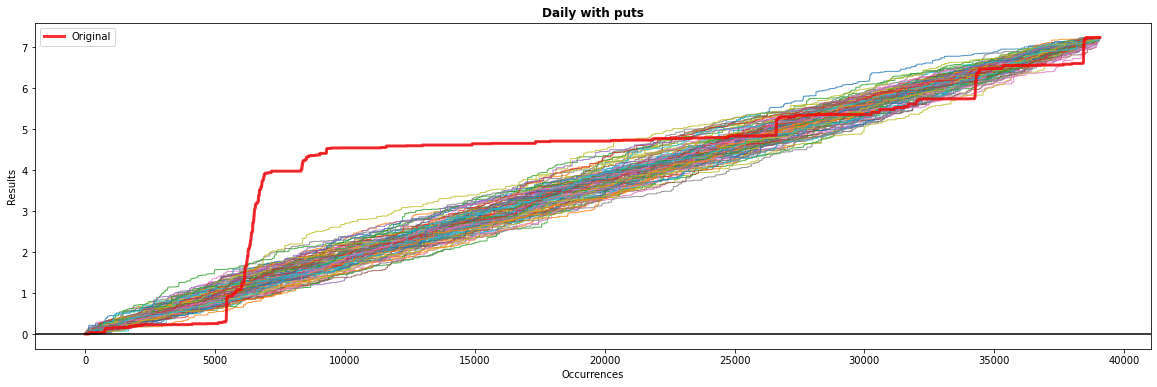

Daily with puts {'min': 7.241952553391457, 'max': 7.241952553391457, 'mean': 7.241952553391457, 'median': 7.241952553391457, 'std': 0.0, 'maxdd': nan, 'bust': 0.0, 'goal': 1.0}


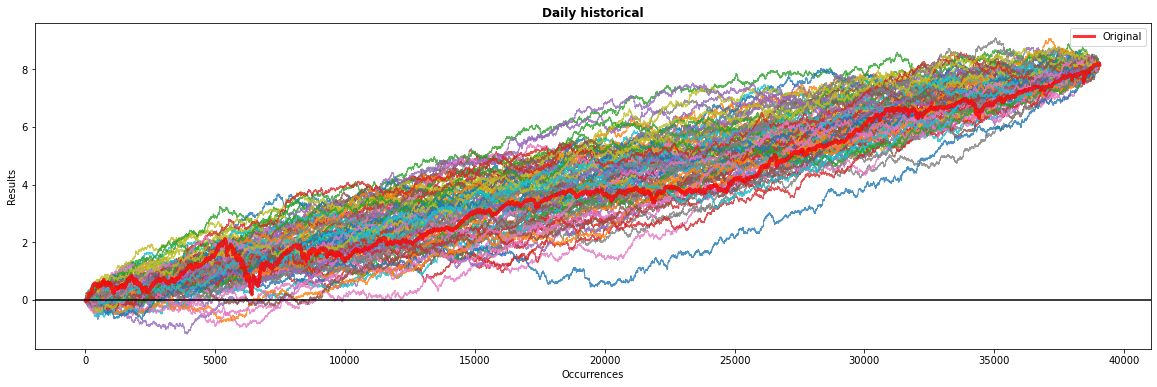

Daily historical {'min': 8.155999302864075, 'max': 8.155999302864075, 'mean': 8.155999302864075, 'median': 8.155999302864075, 'std': 0.0, 'maxdd': -1.1847498416900635, 'bust': 0.25, 'goal': 0.75}


In [59]:
tailCapture(daily, stdev_d*3.5)   
plot(daily, stdev_d*3.5)
montecarlo(daily, "Daily with puts", "gain_pct")
montecarlo(daily, "Daily historical", "pct")

# With cost of options

In [60]:
# Cost of options is percentage expense, always positive.
def tailCapture(df, winThreshold, costOfOptions=0, gainFn=gainFn):
    df["gain_pct"] = df.apply(lambda row: gainFn(row, winThreshold), axis=1)

    startingPortfolioVal = df.head(1)["close"].values[0]
    portfolioVal = startingPortfolioVal
    oldPfVal = startingPortfolioVal  # Only for sanity checks
    pfList = [startingPortfolioVal]
    # shift the gain by 1 week for comparison and iterate over all rows of df2
    for _, row in df.shift(-1).iterrows():
        if np.isnan(row["gain_pct"]):
            continue
        portfolioVal = portfolioVal * (1 - costOfOptions)
        portfolioVal += portfolioVal * row["gain_pct"]
        oldPfVal += oldPfVal * row["pct"] # For sanity checks
        pfList.append(portfolioVal)
    df["portfolio"] = pfList
    print(
        "Strategy ending val ",
        portfolioVal,
        "Discrete periods ",
        len(pfList),
        len(df),
        "Ending val buy and hold ",
        df.tail(1)["close"].values[0],
        oldPfVal,
    )


Strategy ending val  3823.6966151203505 Discrete periods  1801 1801 Ending val buy and hold  3793.748421052632 3793.748421052611
              pct    gain_pct
count  395.000000  395.000000
mean     0.004781    0.026755
std      0.077602    0.038521
min     -0.264737    0.000041
25%     -0.054922    0.006402
50%      0.042697    0.016186
75%      0.057282    0.031290
max      0.502994    0.462298 
            pct  gain_pct
16   -0.051653  0.010957
39   -0.076459  0.035763
40   -0.087146  0.046450
42    0.094059  0.053363
43    0.054299  0.013602
...        ...       ...
1798  0.041314  0.000618
1799  0.057075  0.016379
1800  0.063380  0.022684
1802  0.057392  0.016696
1806  0.041228  0.000532

[395 rows x 2 columns]
Longest streak of 0s:  48
Longest streak of non 0s:  7


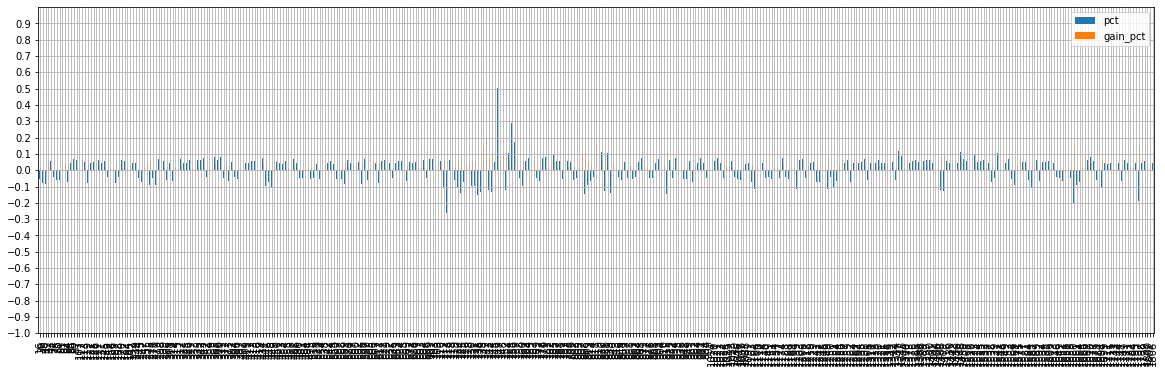

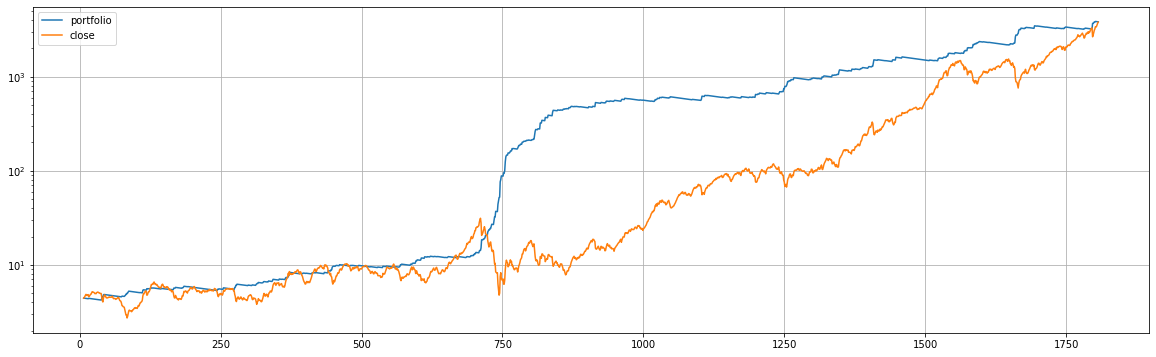

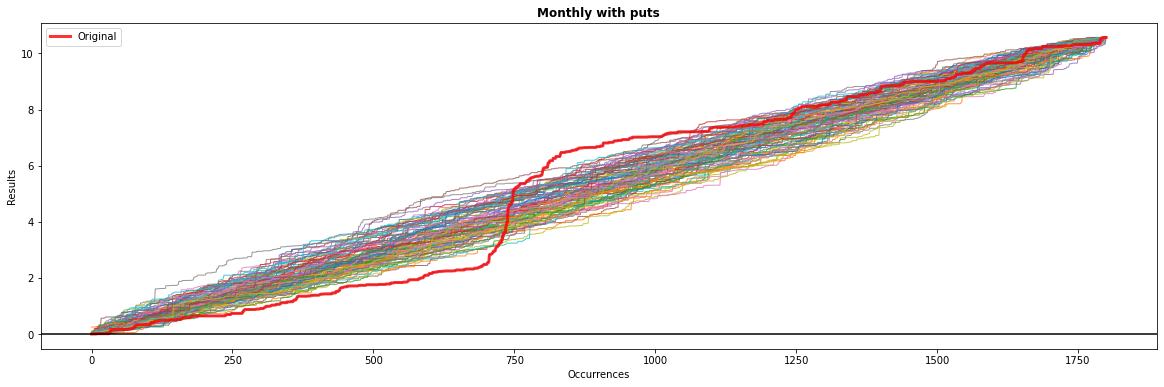

Monthly with puts {'min': 10.568074679105996, 'max': 10.568074679106028, 'mean': 10.568074679106013, 'median': 10.568074679106013, 'std': 6.729916163552617e-15, 'maxdd': nan, 'bust': 0.0, 'goal': 1.0}


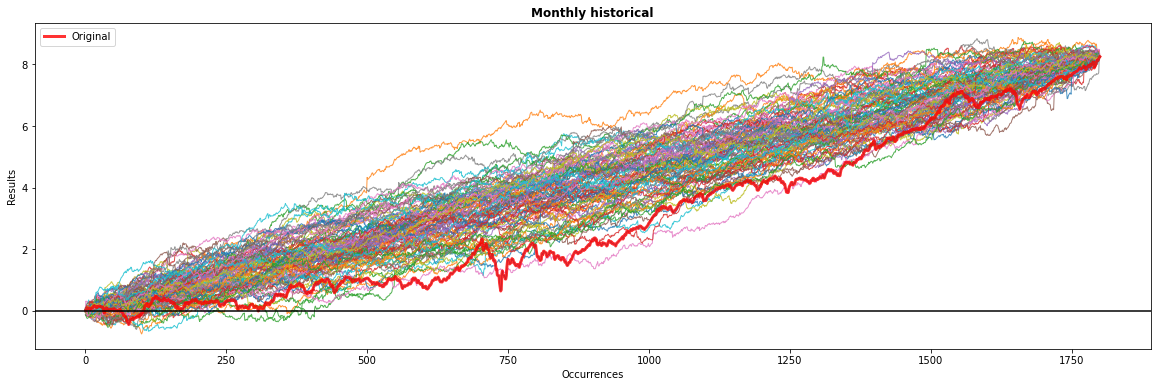

Monthly historical {'min': 8.250132331879199, 'max': 8.250132331879245, 'mean': 8.250132331879227, 'median': 8.250132331879225, 'std': 8.35095751026948e-15, 'maxdd': -0.7575874017703678, 'bust': 0.23, 'goal': 0.77}


In [61]:
tailCapture(monthly, stdev_m, costOfOptions=0.19/100)   
plot(monthly, stdev_m)
montecarlo(monthly, "Monthly with puts", "gain_pct")
montecarlo(monthly, "Monthly historical", "pct")

Strategy ending val  7135.337365167075 Discrete periods  1801 1801 Ending val buy and hold  3793.748421052632 3793.748421052611
             pct   gain_pct
count  70.000000  70.000000
mean   -0.035129   0.043708
std     0.135881   0.061958
min    -0.264737   0.000462
25%    -0.120222   0.010923
50%    -0.092605   0.026120
75%     0.091630   0.050254
max     0.502994   0.421602 
            pct  gain_pct
40   -0.087146  0.005754
42    0.094059  0.012667
112   0.109005  0.027612
275  -0.088512  0.007120
277  -0.093275  0.011883
...        ...       ...
1660 -0.203911  0.122519
1661 -0.088522  0.007130
1666  0.120217  0.038825
1694 -0.105555  0.024162
1797 -0.190681  0.109288

[70 rows x 2 columns]
Longest streak of 0s:  188
Longest streak of non 0s:  3


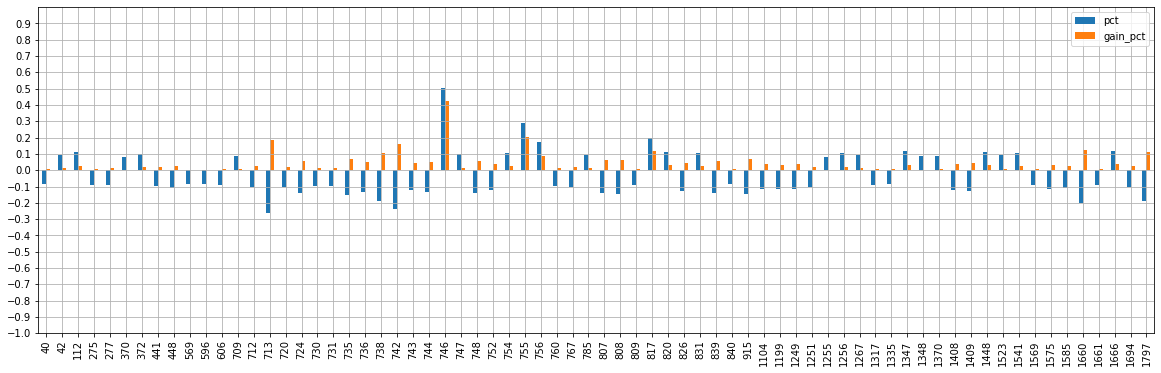

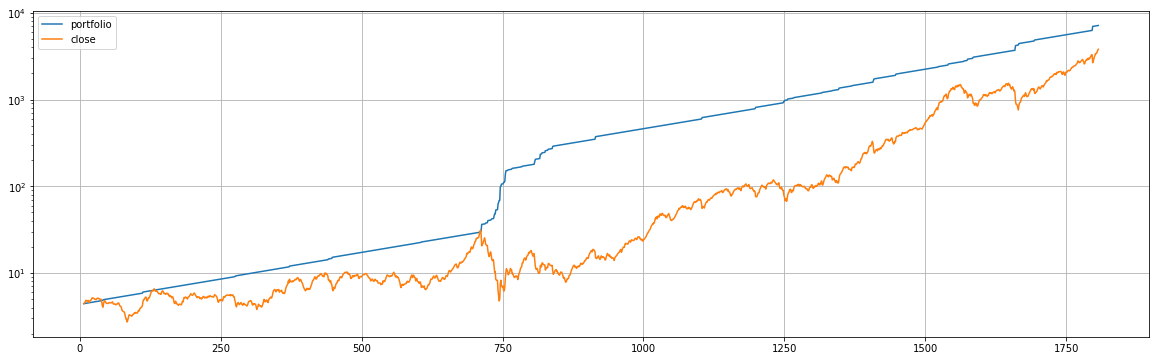

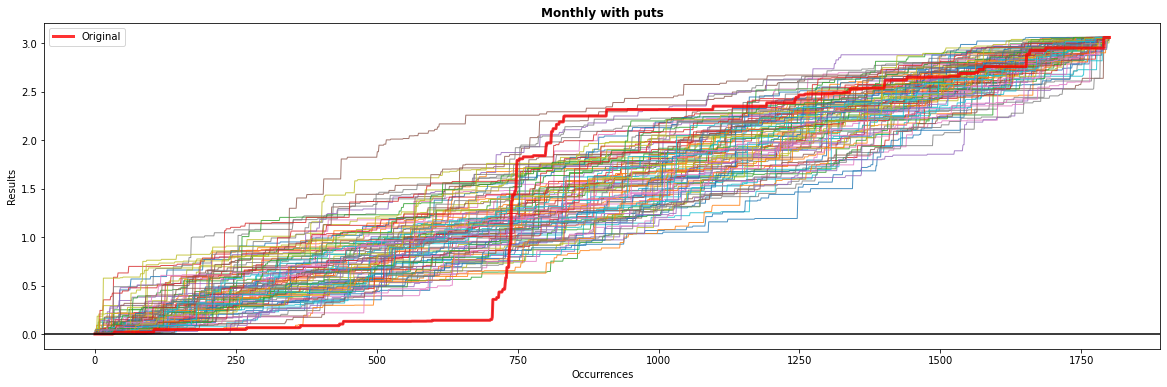

Monthly with puts {'min': 3.0595460908036385, 'max': 3.059546090803642, 'mean': 3.05954609080364, 'median': 3.0595460908036403, 'std': 1.0128759012761197e-15, 'maxdd': nan, 'bust': 0.0, 'goal': 1.0}


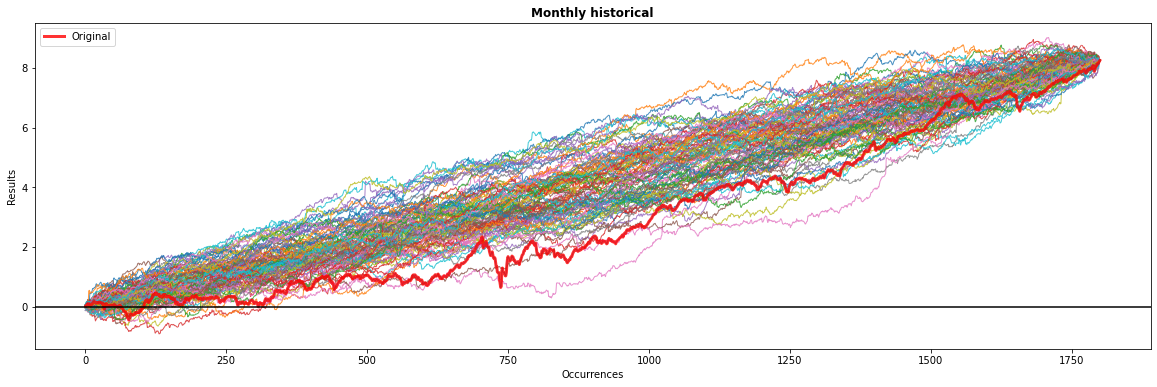

Monthly historical {'min': 8.250132331879204, 'max': 8.250132331879245, 'mean': 8.250132331879225, 'median': 8.250132331879227, 'std': 8.689376161218594e-15, 'maxdd': -0.9210659090529801, 'bust': 0.24, 'goal': 0.75}


In [68]:
# How much interest does the rest of the pf need to make for 2SD capture?
costOfOptions = 0.2/100
interest = 0.45/100
tailCapture(monthly, stdev_m*2, costOfOptions=(costOfOptions-interest))   
plot(monthly, stdev_m*2)
montecarlo(monthly, "Monthly with puts", "gain_pct")
montecarlo(monthly, "Monthly historical", "pct")

### NOTE: This is just past data analysis, the only certainty is that the future will NOT resemble the past!

# With insurance (rest of the pf invested in mkt)

In [69]:

# Cost of options is percentage expense, always positive.
def insured(df, winThreshold, costOfOptions=0, gainFn=gainFnPutsOnly):
    df["gain_pct"] = df.apply(lambda row: gainFn(row, winThreshold), axis=1)

    startingPortfolioVal = df.head(1)["close"].values[0]
    portfolioVal = startingPortfolioVal
    oldPfVal = startingPortfolioVal  # Only for sanity checks
    pfList = [startingPortfolioVal]
    # shift the gain by 1 week for comparison and iterate over all rows of df2
    for _, row in df.shift(-1).iterrows():
        if np.isnan(row["gain_pct"]):
            continue

        marketPfStartVal = portfolioVal * (1 - costOfOptions)
        marketPfEndVal = marketPfStartVal * (1 + row["pct"])

        putsGain = portfolioVal * row["gain_pct"]
        portfolioVal = marketPfEndVal + putsGain
        oldPfVal += oldPfVal * row["pct"] # For sanity checks
        pfList.append(portfolioVal)
    df["portfolio"] = pfList
    print(
        "Strategy ending val ",
        portfolioVal,
        "Discrete periods ",
        len(pfList),
        len(df),
        "Ending val buy and hold ",
        df.tail(1)["close"].values[0],
        oldPfVal,
    )


Strategy ending val  5255.571345645055 Discrete periods  1801 1801 Ending val buy and hold  3793.748421052632 3793.748421052611
             pct   gain_pct
count  70.000000  70.000000
mean   -0.035129   0.026628
std     0.135881   0.037662
min    -0.264737   0.000000
25%    -0.120222   0.000000
50%    -0.092605   0.011212
75%     0.091630   0.038829
max     0.502994   0.183345 
            pct  gain_pct
40   -0.087146  0.005754
42    0.094059  0.000000
112   0.109005  0.000000
275  -0.088512  0.007120
277  -0.093275  0.011883
...        ...       ...
1660 -0.203911  0.122519
1661 -0.088522  0.007130
1666  0.120217  0.000000
1694 -0.105555  0.024162
1797 -0.190681  0.109288

[70 rows x 2 columns]
Longest streak of 0s:  234
Longest streak of non 0s:  3


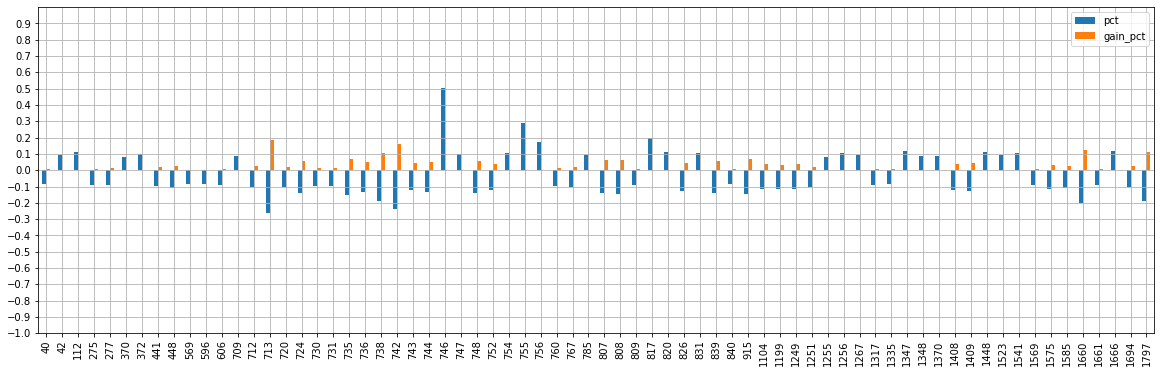

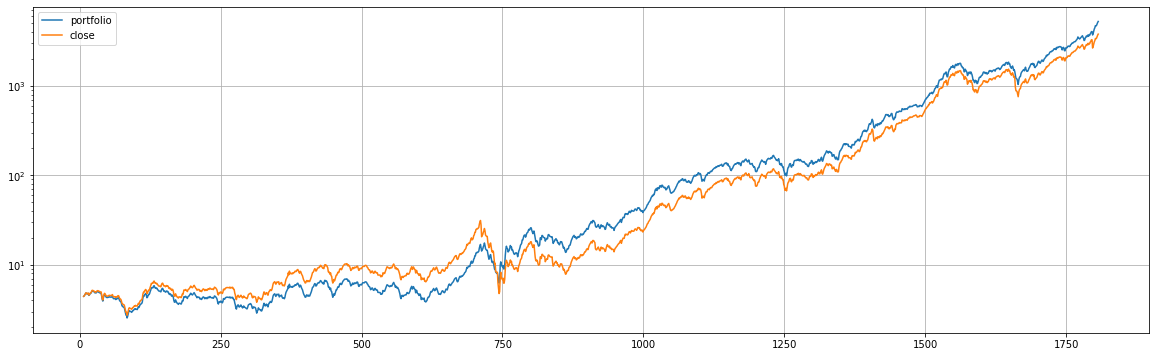

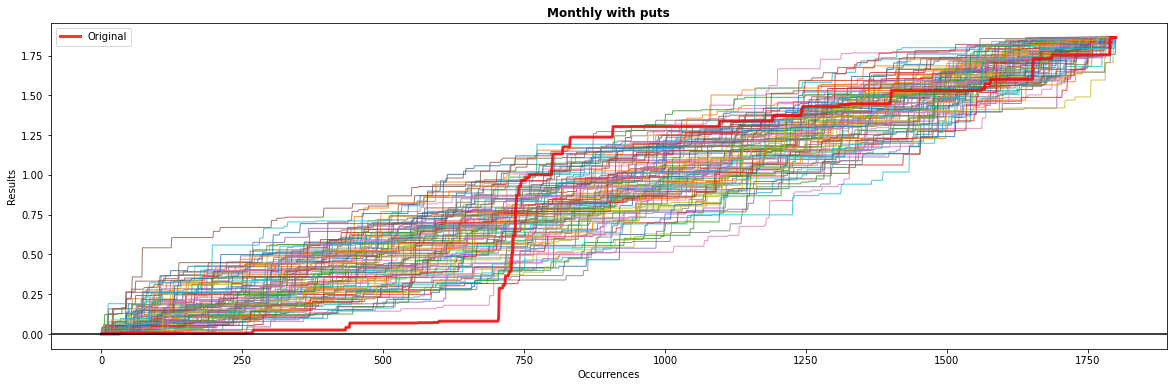

Monthly with puts {'min': 1.8639581367391969, 'max': 1.8639581367391984, 'mean': 1.8639581367391975, 'median': 1.8639581367391977, 'std': 3.171745357773994e-16, 'maxdd': nan, 'bust': 0.0, 'goal': 0.0}


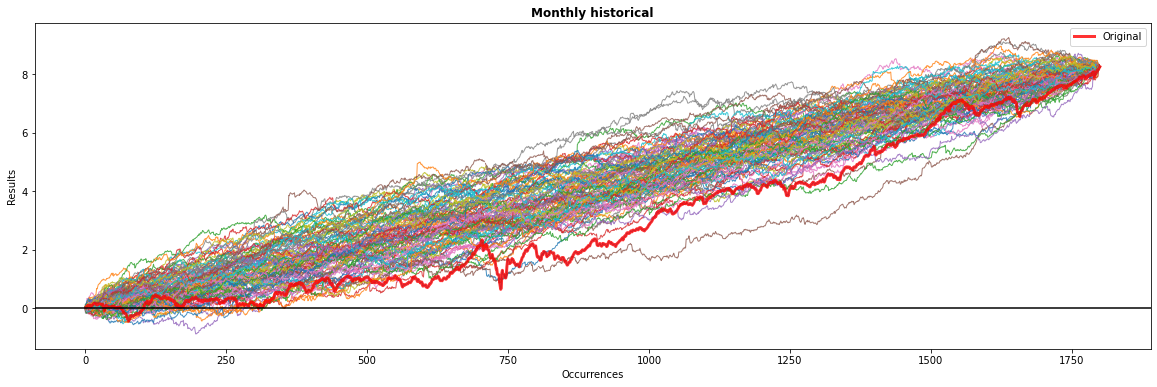

Monthly historical {'min': 8.250132331879202, 'max': 8.250132331879243, 'mean': 8.250132331879223, 'median': 8.250132331879223, 'std': 8.595464104033564e-15, 'maxdd': -0.8874949585285316, 'bust': 0.22, 'goal': 0.78}


In [75]:

insured(monthly, stdev_m*2, gainFn=gainFnPutsOnly, costOfOptions=0.1/100)   
plot(monthly, stdev_m*2)
montecarlo(monthly, "Monthly with puts", "gain_pct")
montecarlo(monthly, "Monthly historical", "pct")

Strategy ending val  30182.765737784055 Discrete periods  5582 5582 Ending val buy and hold  34483.72 34483.66855370661
             pct   gain_pct
count  83.000000  83.000000
mean   -0.011651   0.016623
std     0.110812   0.026306
min    -0.181513   0.000000
25%    -0.095724   0.000000
50%    -0.076504   0.001406
75%     0.094650   0.020626
max     0.226686   0.106415 
                  pct  gain_pct
Datetime                      
1915-05-09 -0.122221  0.047123
1917-11-04 -0.083513  0.008415
1920-04-25 -0.083198  0.008100
1928-12-09 -0.115096  0.039998
1929-10-20 -0.081715  0.006617
...              ...       ...
2020-03-01 -0.123586  0.048488
2020-03-15 -0.103583  0.028485
2020-03-22 -0.173023  0.097925
2020-03-29  0.128445  0.000000
2020-04-12  0.126675  0.000000

[83 rows x 2 columns]
Longest streak of 0s:  2473
Longest streak of non 0s:  4


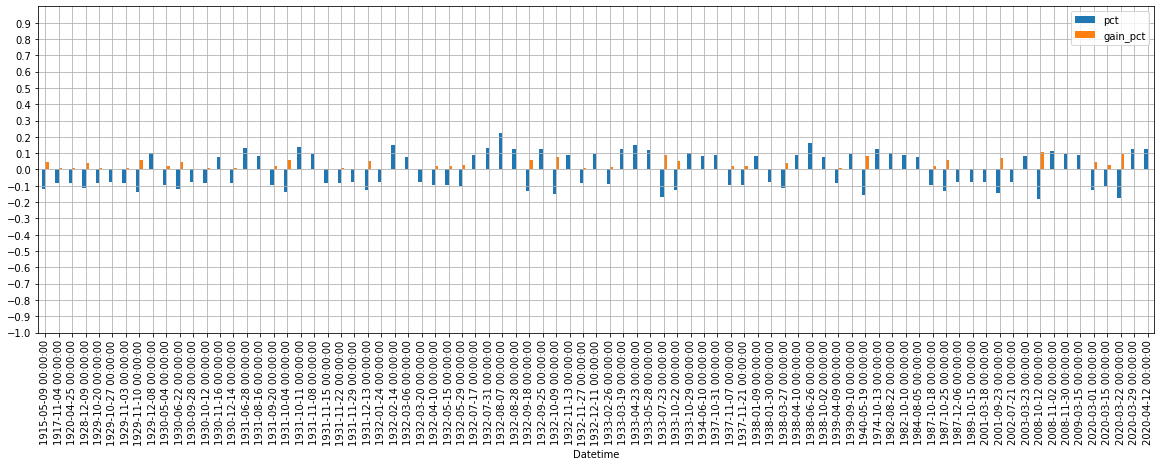

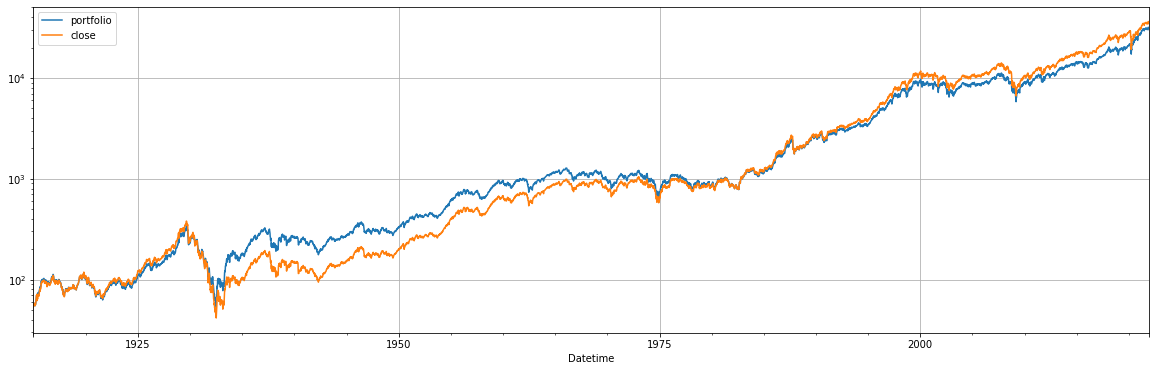

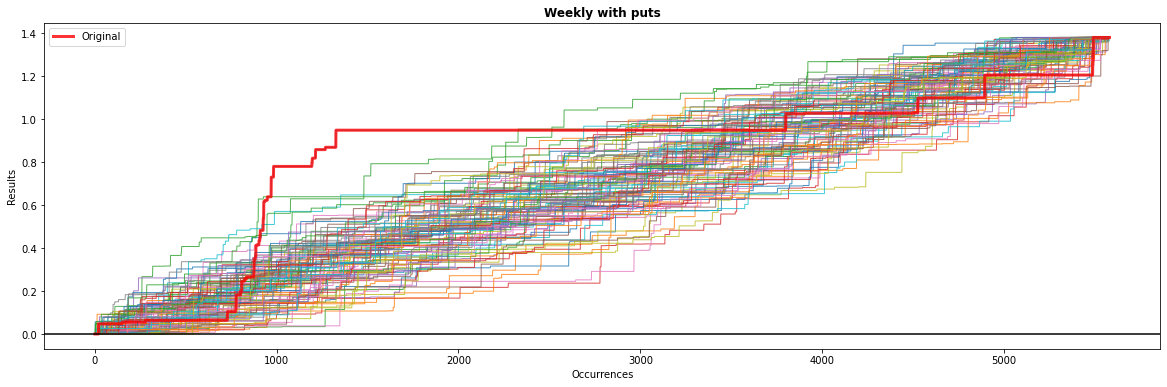

Weekly with puts {'min': 1.3796946667134762, 'max': 1.3796946667134762, 'mean': 1.3796946667134762, 'median': 1.3796946667134762, 'std': 0.0, 'maxdd': nan, 'bust': 0.0, 'goal': 0.0}


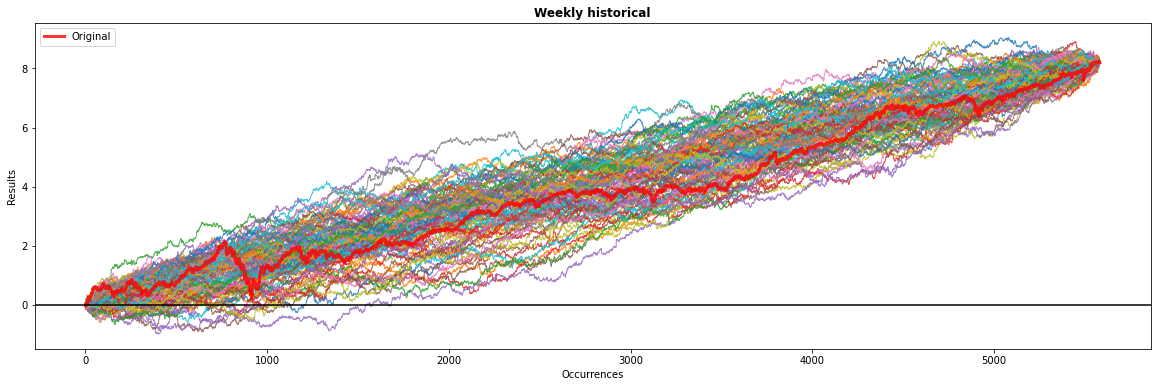

Weekly historical {'min': 8.19879025220871, 'max': 8.19879025220871, 'mean': 8.19879025220871, 'median': 8.19879025220871, 'std': 0.0, 'maxdd': -0.9866122603416443, 'bust': 0.32, 'goal': 0.68}


In [71]:

insured(weekly, stdev_w*3, gainFn=gainFnPutsOnly, costOfOptions=0.03/100)   
plot(weekly, stdev_w*3)
montecarlo(weekly, "Weekly with puts", "gain_pct")
montecarlo(weekly, "Weekly historical", "pct")

#### NOTES

* Sounds simple, but there was a period of 47yrs or so where nothing happened! With 3 SD, the period between the strategy working can be so long that you might die in the interim. (The Tartar Steppe story in which Giovanni Drogo is posted on the Bastianni Fortress)

In [194]:
# If you want to dump to csv
# df2["power"] = pfList
# df2.to_csv("/Users/shan/Documents/power3.csv", index=False)

/var/folders/b7/nt75slqx7lgc80c_xh9gxg640000gn/T/ipykernel_93425/1493197684.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

